<style>
body {
    max-width: 900px;
    margin: 40px auto;
    padding: 0 20px;
    font-family: "Georgia", serif;
    line-height: 1.6;
}
</style>

<div style="text-align: center; padding: 60px 60px">
  <h1 style="font-weight: bold; font-size: 3.1em">
    GA-UFLP-2
  </h1>
</div>

## **CONFIGURACIÓN DE LA NOTEBOOK**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [7]:
import numpy as np
from numba import njit
import random
import time

@njit
def calcular_fitness_numba(indices_instalaciones_abiertas, costos_fijos, costos_transporte):
    # Si no hay instalaciones abiertas, devuelve un costo muy alto para penalizar esta solucion.
    if indices_instalaciones_abiertas.size == 0:
        return 1e10  # Alta penalizacion si no hay instalaciones abiertas

    costo_fijo = 0.0
    # Itera sobre los indices de las instalaciones abiertas y suma sus costos fijos.
    for indice in indices_instalaciones_abiertas:
        costo_fijo += costos_fijos[indice]

    costo_transporte = 0.0
    # Itera sobre cada cliente para encontrar el costo de transporte minimo desde una instalacion abierta.
    for cliente in range(costos_transporte.shape[0]): # prange del paralelismo de nucleos!
        costo_minimo = 1e10
        # Itera sobre los indices de las instalaciones abiertas para encontrar la instalacion mas cercana a este cliente.
        for indice_instalacion in indices_instalaciones_abiertas:
            costo = costos_transporte[cliente, indice_instalacion]
            # Si se encuentra un costo de transporte menor, actualiza el costo minimo.
            if costo < costo_minimo:
                costo_minimo = costo
        costo_transporte += costo_minimo  # Acumula el costo de transporte minimo para este cliente.

    return costo_fijo + costo_transporte  # Devuelve la suma del costo fijo total y el costo de transporte total.

@njit
def _crossover_un_punto_numba(solucion1, solucion2):
    longitud1 = solucion1.shape[0]
    longitud2 = solucion2.shape[0]

    if longitud1 < 2 or longitud2 < 2:
        # Volver a una lógica simple si es demasiado corto
        punto = random.randint(0, max(longitud1, longitud2))
        descendiente1 = np.sort(np.concatenate((solucion1[:punto], solucion2[punto:])))
        descendiente2 = np.sort(np.concatenate((solucion2[:punto], solucion1[punto:])))
        return descendiente1, descendiente2

    punto_crossover1 = random.randint(1, longitud1 - 1)
    punto_crossover2 = random.randint(1, longitud2 - 1)

    descendiente1 = np.sort(np.concatenate((solucion1[:punto_crossover1], solucion2[punto_crossover2:])))
    descendiente2 = np.sort(np.concatenate((solucion2[:punto_crossover2], solucion1[punto_crossover1:])))

    # Asegurar que al menos una instalación esté abierta (versión Numba-friendly)
    if descendiente1.shape[0] == 0:
        union = np.unique(np.concatenate((solucion1, solucion2)))
        if union.shape[0] > 0:
            descendiente1 = np.array([random.choice(union)])
    if descendiente2.shape[0] == 0:
        union = np.unique(np.concatenate((solucion1, solucion2)))
        if union.shape[0] > 0:
            descendiente2 = np.array([random.choice(union)])

    return descendiente1, descendiente2

def _crossover_un_punto_optimizado(self, padre1, padre2):
    solucion1 = padre1['solucion']
    solucion2 = padre2['solucion']
    descendiente1_indices, descendiente2_indices = _crossover_un_punto_numba(solucion1, solucion2)
    return {'solucion': descendiente1_indices, 'fitness': None}, {'solucion': descendiente2_indices, 'fitness': None}



class UFLP_GA:
    def __init__(self, n_instalaciones, n_clientes, costos_fijos, costos_transporte,
                 tamaño_poblacion=50, tasa_mutacion=0.1, tasa_crossover=0.8,
                 tamaño_torneo=3, max_generaciones=100, tipo_crossover='uniforme'):
        self.n_instalaciones = n_instalaciones
        self.n_clientes = n_clientes
        self.costos_fijos = np.array(costos_fijos[1:])  # Ignorar el indice 0 porque los indices en Python empiezan desde 0.
        self.costos_transporte = np.array(costos_transporte[1:])[:, 1:]  # Ignorar el indice 0 para clientes e instalaciones.
        self.tamaño_poblacion = tamaño_poblacion
        self.tasa_mutacion = tasa_mutacion
        self.tasa_crossover = tasa_crossover
        self.tamaño_torneo = tamaño_torneo
        self.max_generaciones = max_generaciones
        self.tipo_crossover = tipo_crossover
        self.poblacion = []
        self.generacion = 0
        self.mejor_solucion = None  # Almacenara los indices de las instalaciones abiertas
        self.mejor_fitness = float('inf')  # Inicializar con un valor muy grande para asegurar que se encuentre un mejor valor.
        self.mejor_asignacion_clientes = None # Inicializar aquí también
        self.historial_fitness = []

    def _generar_individuo(self):
        num_abiertas = random.randint(1, self.n_instalaciones)  # Elige un número aleatorio de instalaciones para abrir.
        indices_abiertos = np.sort(np.random.choice(self.n_instalaciones, size=num_abiertas, replace=False))  # Selecciona aleatoriamente instalaciones únicas.
        return {'solucion': indices_abiertos, 'fitness': None}  # Devuelve el individuo con la solucion y fitness sin calcular.

    def _inicializar_poblacion(self):
        self.poblacion = [self._generar_individuo() for _ in range(self.tamaño_poblacion)]  # Crea una lista de individuos aleatorios.
        self._evaluar_poblacion()  # Calcula la fitness de cada individuo en la poblacion.
        self.poblacion.sort(key=lambda ind: ind['fitness'])  # Ordena la poblacion según la fitness (de menor a mayor).
        self.mejor_solucion = self.poblacion[0]['solucion'].copy()  # Almacena la mejor solucion encontrada hasta ahora.
        self.mejor_fitness = self.poblacion[0]['fitness']  # Almacena la mejor fitness encontrada hasta ahora.
        self.historial_fitness.append(self.mejor_fitness)  # Guarda la mejor fitness en el historial.

    def _calcular_fitness(self, individuo):
        return calcular_fitness_numba(
            individuo['solucion'],
            self.costos_fijos,
            self.costos_transporte
        )

    def _evaluar_poblacion(self):
        for individuo in self.poblacion:
            individuo['fitness'] = self._calcular_fitness(individuo)  # Calcula la fitness del individuo.
            if individuo['fitness'] < self.mejor_fitness:  # Si la fitness es mejor que la mejor encontrada hasta ahora:
                self.mejor_fitness = individuo['fitness']  # Actualiza la mejor fitness.
                self.mejor_solucion = individuo['solucion'].copy()  # Actualiza la mejor solucion.

    def _seleccion_torneo(self):
        torneo = random.sample(self.poblacion, self.tamaño_torneo)  # Selecciona un subconjunto aleatorio de la poblacion.
        ganador = min(torneo, key=lambda ind: ind['fitness'])  # Encuentra al individuo con la mejor fitness en el torneo.
        return ganador  # Devuelve al ganador del torneo.

    def _crossover_uniforme(self, padre1, padre2):
        conjunto1 = set(padre1['solucion'])
        conjunto2 = set(padre2['solucion'])
        union_conjunto = conjunto1.union(conjunto2)  # Obtiene el conjunto de todas las instalaciones abiertas por ambos padres.
        # interseccion_conjunto = conjunto1.intersection(conjunto2) # Obtiene el conjunto de instalaciones abiertas por ambos padres

        descendiente1_indices = []
        descendiente2_indices = []

        # Itera sobre todas las instalaciones únicas abiertas por los padres.
        for indice_instalacion in union_conjunto:
            if random.random() < 0.5:  # Decide aleatoriamente de qué padre hereda la instalacion.
                descendiente1_indices.append(indice_instalacion)  # Agrega la instalacion al primer descendiente.
            else:
                descendiente2_indices.append(indice_instalacion)  # Agrega la instalacion al segundo descendiente.

        # Asegurar que al menos una instalacion esté abierta
        if not descendiente1_indices:
            descendiente1_indices.append(random.choice(list(union_conjunto)))
        if not descendiente2_indices:
            descendiente2_indices.append(random.choice(list(union_conjunto)))

        # Devuelve los descendientes con las instalaciones abiertas y fitness sin calcular.
        return {'solucion': np.sort(np.array(list(descendiente1_indices))), 'fitness': None}, \
               {'solucion': np.sort(np.array(list(descendiente2_indices))), 'fitness': None}

    def _crossover_un_punto(self, padre1, padre2):
        solucion1 = padre1['solucion']
        solucion2 = padre2['solucion']
        longitud1 = len(solucion1)
        longitud2 = len(solucion2)

        if longitud1 < 2 or longitud2 < 2:
            return self._crossover_uniforme(padre1, padre2)  # Volver a uniforme si es demasiado corto

        punto_crossover1 = random.randint(1, longitud1 - 1)
        punto_crossover2 = random.randint(1, longitud2 - 1)

        descendiente1_indices = np.sort(np.concatenate((solucion1[:punto_crossover1], solucion2[punto_crossover2:])))
        descendiente2_indices = np.sort(np.concatenate((solucion2[:punto_crossover2], solucion1[punto_crossover1:])))

        # Asegurar que al menos una instalacion esté abierta
        if not descendiente1_indices.size:
            descendiente1_indices = np.array([random.choice(np.concatenate((solucion1, solucion2)))])
        if not descendiente2_indices.size:
            descendiente2_indices = np.array([random.choice(np.concatenate((solucion1, solucion2)))])

        return {'solucion': descendiente1_indices, 'fitness': None}, {'solucion': descendiente2_indices, 'fitness': None}

    def _operador_crossover(self, padre1, padre2):
        if self.tipo_crossover == 'uniforme':
            return self._crossover_uniforme(padre1, padre2)
        elif self.tipo_crossover == 'un_punto':
            return self._crossover_un_punto(padre1, padre2)
        else:
            raise ValueError("Tipo de crossover desconocido")

    def _mutar(self, individuo):
        indices_mutados = list(individuo['solucion'])
        num_abiertas = len(indices_mutados)

        if random.random() < self.tasa_mutacion:
            if num_abiertas > 1 and random.random() < 0.33:  # Eliminar una instalacion
                indice_eliminar = random.randint(0, num_abiertas - 1)
                indices_mutados.pop(indice_eliminar)
            elif num_abiertas < self.n_instalaciones and random.random() < 0.66:  # Agregar una instalacion
                indices_cerradas = np.array([i for i in range(self.n_instalaciones) if i not in indices_mutados])
                if indices_cerradas.size > 0:
                    indice_agregar = random.choice(indices_cerradas)
                    indices_mutados.append(indice_agregar)
            elif num_abiertas > 0 and self.n_instalaciones > num_abiertas: # Intercambiar una instalacion
                indice_eliminar = random.randint(0, num_abiertas - 1)
                indices_cerradas = np.array([i for i in range(self.n_instalaciones) if i not in indices_mutados])
                if indices_cerradas.size > 0:
                    indice_agregar = random.choice(indices_cerradas)
                    indices_mutados[indice_eliminar] = indice_agregar

        return {'solucion': np.sort(np.array(indices_mutados)), 'fitness': None}

    def _reemplazo(self, nueva_poblacion):
        for individuo in nueva_poblacion:
            if individuo['fitness'] is None:
                individuo['fitness'] = self._calcular_fitness(individuo)
        nueva_poblacion.append({'solucion': self.mejor_solucion.copy(), 'fitness': self.mejor_fitness})
        nueva_poblacion.sort(key=lambda ind: ind['fitness'])
        self.poblacion = nueva_poblacion[:self.tamaño_poblacion]

    def run(self):
        tiempo_inicio = time.time()
        self._inicializar_poblacion()

        for generacion in range(self.max_generaciones):
            self.generacion = generacion
            nueva_poblacion = []
            while len(nueva_poblacion) < self.tamaño_poblacion - 1:
                padre1 = self._seleccion_torneo()
                padre2 = self._seleccion_torneo()
                if random.random() < self.tasa_crossover:
                    descendiente1, descendiente2 = self._operador_crossover(padre1, padre2)
                    nueva_poblacion.append(self._mutar(descendiente1))
                    nueva_poblacion.append(self._mutar(descendiente2))
                else:
                    nueva_poblacion.append(self._mutar({'solucion': padre1['solucion'].copy(), 'fitness': None}))
                    nueva_poblacion.append(self._mutar({'solucion': padre2['solucion'].copy(), 'fitness': None}))

            self._reemplazo(nueva_poblacion)
            self._evaluar_poblacion()
            self.historial_fitness.append(self.mejor_fitness)

        tiempo_fin = time.time()
        return self.mejor_solucion, self.mejor_fitness, self.historial_fitness, tiempo_fin - tiempo_inicio, self.generacion + 1
class UFLP_GA_Optimizado(UFLP_GA):
    def _crossover_un_punto(self, padre1, padre2):
        return _crossover_un_punto_optimizado(self, padre1, padre2)
    
# Ejemplo de uso con la clase optimizada
if __name__ == '__main__':
    n_instalaciones = 20
    n_clientes = 50
    costos_fijos = [0] + list(np.random.rand(n_instalaciones) * 100)
    costos_transporte = np.concatenate(([0] * (n_clientes + 1), np.random.rand(n_clientes * n_instalaciones) * 10), axis=0).reshape(n_clientes + 1, n_instalaciones + 1)

    ga_original = UFLP_GA(n_instalaciones, n_clientes, costos_fijos, costos_transporte, tipo_crossover='un_punto')
    tiempo_inicio = time.time()
    mejor_solucion_orig, mejor_fitness_orig, _, tiempo_ejecucion_orig, generaciones_orig = ga_original.run()
    tiempo_fin = time.time()
    print(f"Tiempo de ejecución (original): {tiempo_ejecucion_orig:.4f} segundos")
    print(f"Mejor fitness (original): {mejor_fitness_orig:.4f}")

    ga_optimizado = UFLP_GA_Optimizado(n_instalaciones, n_clientes, costos_fijos, costos_transporte, tipo_crossover='un_punto')
    tiempo_inicio = time.time()
    mejor_solucion_opt, mejor_fitness_opt, _, tiempo_ejecucion_opt, generaciones_opt = ga_optimizado.run()
    tiempo_fin = time.time()
    print(f"Tiempo de ejecución (optimizado con Numba): {tiempo_ejecucion_opt:.4f} segundos")
    print(f"Mejor fitness (optimizado con Numba): {mejor_fitness_opt:.4f}")

ValueError: cannot reshape array of size 1051 into shape (51,21)

In [2]:
from cargar_datos import *
from ga_uflp import *

In [3]:
sns.set(style="whitegrid")
sns.set_palette("tab10")

# Personalizacion global con matplotlib
plt.rcParams.update({
    'axes.titlesize': 20,        # Tamaño del titulo
    'axes.titleweight': 'bold',  # Negrita en el titulo
    'xtick.labelsize': 8,        # Tamaño de los xticks
    'ytick.labelsize': 8,         # Tamaño de los yticks
    'grid.color': 'gray',         # Color de las lineas del grid
    'grid.linestyle': '--',       # Estilo de linea (puede ser '-', '--', '-.', ':')
    'grid.linewidth': 0.5,        # Grosor del grid
    'axes.grid': True,            # Asegura que el grid esté activado
    'axes.grid.axis': 'both',     # Aplica el grid a ambos ejes
    'lines.linewidth': 1.2,       # Grosor de las lineas
    'figure.figsize': (12, 6),   # Tamaño de la figura
})

# **CARGAR DATOS**

In [4]:
file_name = 'UFLP-2'

In [5]:
n_instalaciones, n_clientes, costos_fijos, costos_de_transporte = cargar_datos('datos/'+file_name+'.txt')

# **HIPERPARÁMETROS**

In [6]:
num_ejecuciones = 9
resultados = {}
random_seed = 8

path = "resultados"
os.makedirs(os.path.join(path, file_name), exist_ok=True)

In [7]:
configuraciones = [
    # Mejor solucion
    {
        "tamaño_de_poblacion": 321,
        "tasa_de_mutacion": 0.6,
        "tasa_de_crossover": 0.6,
        "tamaño_del_torneo": 16,
        "maximo_de_generaciones": 1000,
        "tipo_de_crossover": "un_punto"
    },
    # Solucion mas rapida
    {
        "tamaño_de_poblacion": 30,
        "tasa_de_mutacion": 0.1,
        "tasa_de_crossover": 0.8,
        "tamaño_del_torneo": 3,
        "maximo_de_generaciones": 1000,
        "tipo_de_crossover": "uniforme"
    }
]

# **EJECUCIÓN**

In [8]:
print(f"Ejecutando GA para {file_name} con semilla aleatoria: {random_seed}\n")

for config in configuraciones:
    nombre_configuracion = f"TamPob_{config['tamaño_de_poblacion']}_TasaMut_{config['tasa_de_mutacion']}_TasaCruz_{config['tasa_de_crossover']}_TamTorneo_{config['tamaño_del_torneo']}_MaxGen_{config['maximo_de_generaciones']}_{config['tipo_de_crossover']}"
    print(f"--- Ejecutando configuracion: {nombre_configuracion} ---")
    resultados[nombre_configuracion] = []

    for ejecucion in range(num_ejecuciones):
        ga = UFLP_GA(n_instalaciones, n_clientes, costos_fijos, costos_de_transporte,
                     config["tamaño_de_poblacion"], config["tasa_de_mutacion"], config["tasa_de_crossover"],
                     config["tamaño_del_torneo"], config["maximo_de_generaciones"])
        if config["tipo_de_crossover"] == "uniforme":
            ga._operador_de_crossover = ga._crossover_uniforme
        elif config["tipo_de_crossover"] == "un_punto":
            ga._operador_de_crossover = ga._crossover_un_punto
        else:
            raise ValueError(f"Tipo de crossover desconocido: {config['tipo_de_crossover']}")

        mejor_solucion, mejor_fitness, historial_de_fitnesses, tiempo_de_ejecucion, num_generaciones = ga.run()
        resultados[nombre_configuracion].append({
            "mejor_solucion": mejor_solucion+1,
            "mejor_costo": mejor_fitness,
            "tiempo_de_ejecucion": tiempo_de_ejecucion,
            "num_generaciones": num_generaciones,
            "historial_de_fitnesses": historial_de_fitnesses,
            "costos_de_transporte": ga.costos_transporte
        })
        print(f"Ejecucion {ejecucion + 1}/{num_ejecuciones}: Mejor Costo = {mejor_fitness:.2f}, Tiempo = {tiempo_de_ejecucion:.2f}s, Generaciones = {num_generaciones}")
    print("\n")

Ejecutando GA para UFLP-2 con semilla aleatoria: 8

--- Ejecutando configuracion: TamPob_321_TasaMut_0.6_TasaCruz_0.6_TamTorneo_16_MaxGen_1000_un_punto ---
Ejecucion 1/9: Mejor Costo = 22119.00, Tiempo = 8.32s, Generaciones = 1000
Ejecucion 2/9: Mejor Costo = 22119.00, Tiempo = 8.15s, Generaciones = 1000
Ejecucion 3/9: Mejor Costo = 22119.00, Tiempo = 8.00s, Generaciones = 1000
Ejecucion 4/9: Mejor Costo = 22119.00, Tiempo = 7.79s, Generaciones = 1000
Ejecucion 5/9: Mejor Costo = 22119.00, Tiempo = 7.99s, Generaciones = 1000
Ejecucion 6/9: Mejor Costo = 22119.00, Tiempo = 7.80s, Generaciones = 1000
Ejecucion 7/9: Mejor Costo = 22119.00, Tiempo = 8.09s, Generaciones = 1000
Ejecucion 8/9: Mejor Costo = 22119.00, Tiempo = 7.86s, Generaciones = 1000
Ejecucion 9/9: Mejor Costo = 22119.00, Tiempo = 7.87s, Generaciones = 1000


--- Ejecutando configuracion: TamPob_30_TasaMut_0.1_TasaCruz_0.8_TamTorneo_3_MaxGen_1000_uniforme ---
Ejecucion 1/9: Mejor Costo = 22119.00, Tiempo = 0.48s, Generacion

# **RESUMEN**

In [9]:
tablas_resumen = {}
for nombre_configuracion, resultados_ejecuciones in resultados.items():
    costos = [res["mejor_costo"] for res in resultados_ejecuciones]
    tiempos = [res["tiempo_de_ejecucion"] for res in resultados_ejecuciones]
    mejor_costo = min(costos)
    peor_costo = max(costos)
    costo_promedio = np.mean(costos)
    desviacion_estandar_costo = np.std(costos)
    tiempo_promedio = np.mean(tiempos)
    desviacion_porcentual = (peor_costo - mejor_costo) / mejor_costo * 100 if mejor_costo != 0 else np.inf

    tablas_resumen[nombre_configuracion] = pd.DataFrame({
        "Métrica": ["Mejor Costo", "Peor Costo", "Costo Promedio", "Desviacion Estandar Costo", "Tiempo Promedio de Ejecucion (s)", "Desviacion Porcentual (%)"],
        "Valor": [f"{mejor_costo:.2f}", f"{peor_costo:.2f}", f"{costo_promedio:.2f}", f"{desviacion_estandar_costo:.2f}", f"{tiempo_promedio:.2f}", f"{desviacion_porcentual:.2f}"]
    })

    os.makedirs(os.path.join(path, file_name, nombre_configuracion), exist_ok=True)

In [10]:
print("\n--- Estadisticas de Resumen por Configuracion ---")
for nombre_configuracion, resumen_df in tablas_resumen.items():
    print(f"\nConfiguracion: {nombre_configuracion}")
    print(resumen_df.to_string(index=False))
    resumen_df.to_csv(os.path.join(path, file_name, nombre_configuracion, f"resumen.csv"), index=False)


--- Estadisticas de Resumen por Configuracion ---

Configuracion: TamPob_321_TasaMut_0.6_TasaCruz_0.6_TamTorneo_16_MaxGen_1000_un_punto
                         Métrica    Valor
                     Mejor Costo 22119.00
                      Peor Costo 22119.00
                  Costo Promedio 22119.00
       Desviacion Estandar Costo     0.00
Tiempo Promedio de Ejecucion (s)     7.99
       Desviacion Porcentual (%)     0.00

Configuracion: TamPob_30_TasaMut_0.1_TasaCruz_0.8_TamTorneo_3_MaxGen_1000_uniforme
                         Métrica    Valor
                     Mejor Costo 22119.00
                      Peor Costo 22119.00
                  Costo Promedio 22119.00
       Desviacion Estandar Costo     0.00
Tiempo Promedio de Ejecucion (s)     0.50
       Desviacion Porcentual (%)     0.00


# **GRÁFICAS**

In [11]:
plt.figure(figsize=(12, 6))
for nombre_configuracion, resultados_ejecuciones in resultados.items():
    for i, res in enumerate(resultados_ejecuciones):
        plt.plot(res["historial_de_fitnesses"], label=f"{nombre_configuracion} (Ejecucion {i+1})" if i == 0 else "", alpha=0.3)
    longitud_minima = min(len(res["historial_de_fitnesses"]) for res in resultados_ejecuciones)
    historiales_truncados = [res["historial_de_fitnesses"][:longitud_minima] for res in resultados_ejecuciones]
    historial_promedio_fitnesses = np.mean(historiales_truncados, axis=0)
    plt.plot(historial_promedio_fitnesses, label=f"Prom. {nombre_configuracion}", linewidth=2)
    plt.xlabel("Generacion")
    plt.ylabel("Mejor fitness")
    plt.title("Curva de Convergencia del Mejor Fitness")
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True)
    plt.savefig(os.path.join(path, file_name, nombre_configuracion, f"curvas_convergencia.pdf"), bbox_inches='tight')
    plt.close()

In [12]:
for nombre_configuracion, resultados_ejecuciones in resultados.items():
    plt.figure(figsize=(4, 6))
    costos = [res["mejor_costo"] for res in resultados_ejecuciones]
    plt.boxplot(costos, positions=[list(resultados.keys()).index(nombre_configuracion)], patch_artist=True, widths=0.5)
    plt.xlabel("Configuracion")
    plt.ylabel("Mejor Costo")
    plt.title("Mejores Costos")
    plt.grid(True, axis='y')
    plt.savefig(os.path.join(path, file_name, nombre_configuracion, "boxplot_mejores_costos.pdf"), bbox_inches='tight')
    plt.close()

In [13]:
for nombre_configuracion, resultados_ejecuciones in resultados.items():
    texto = ""
    mejor_ejecucion = min(resultados_ejecuciones, key=lambda x: x["mejor_costo"])
    texto += f"\nConfiguracion: {nombre_configuracion}\n"
    texto += f"  Mejor Solucion (Instalaciones Abiertas): {mejor_ejecucion['mejor_solucion']}\n"
    texto += f"  Mejor Costo: {mejor_ejecucion['mejor_costo']:.2f}\n"
    texto += f"\nSemilla aleatoria utilizada para reproducibilidad: {random_seed}\n"

    texto += f"\nTiempo de Ejecucion: {mejor_ejecucion['tiempo_de_ejecucion']:.2f} segundos\n"

    ruta_archivo = os.path.join(path, file_name, nombre_configuracion, "mejores_soluciones.txt")
    with open(ruta_archivo, "w") as f:
        f.write(texto)

    print("Texto guardado en", ruta_archivo)

Texto guardado en resultados\UFLP-2\TamPob_321_TasaMut_0.6_TasaCruz_0.6_TamTorneo_16_MaxGen_1000_un_punto\mejores_soluciones.txt
Texto guardado en resultados\UFLP-2\TamPob_30_TasaMut_0.1_TasaCruz_0.8_TamTorneo_3_MaxGen_1000_uniforme\mejores_soluciones.txt


# **COMPARACIÓN**

In [14]:
# obtener el nombre completo de las configuraciones
nombrecompleto = ""
for config in resultados.keys():
    nombrecompleto += config

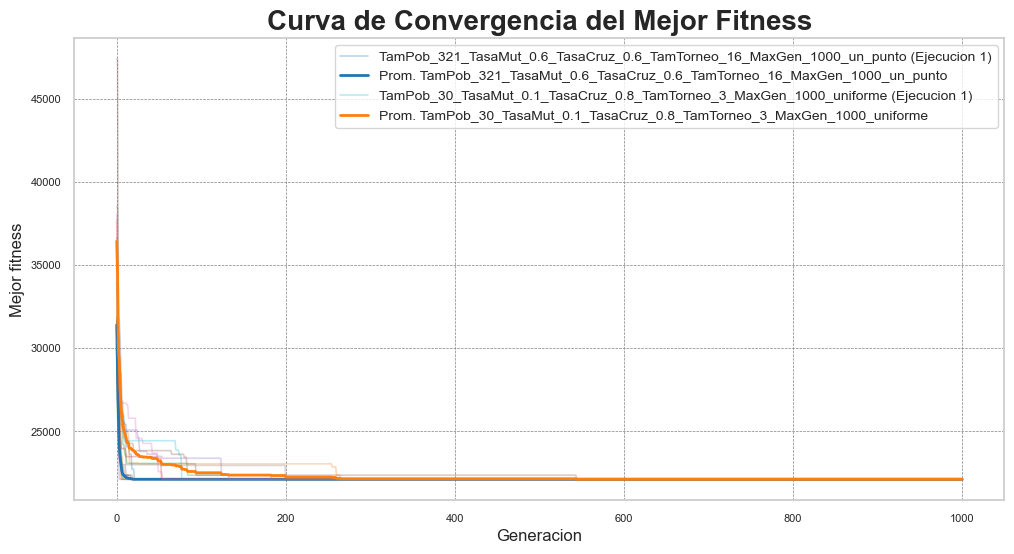

In [15]:
plt.figure(figsize=(12, 6))
for nombre_configuracion, resultados_ejecuciones in resultados.items():
    for i, res in enumerate(resultados_ejecuciones):
        plt.plot(res["historial_de_fitnesses"], label=f"{nombre_configuracion} (Ejecucion {i+1})" if i == 0 else "", alpha=0.3)
    longitud_minima = min(len(res["historial_de_fitnesses"]) for res in resultados_ejecuciones)
    historiales_truncados = [res["historial_de_fitnesses"][:longitud_minima] for res in resultados_ejecuciones]
    historial_promedio_fitnesses = np.mean(historiales_truncados, axis=0)
    plt.plot(historial_promedio_fitnesses, label=f"Prom. {nombre_configuracion}", linewidth=2, color=sns.color_palette("tab10")[list(resultados.keys()).index(nombre_configuracion)])
plt.xlabel("Generacion")
plt.ylabel("Mejor fitness")
plt.title("Curva de Convergencia del Mejor Fitness")
plt.legend(loc='upper right', fontsize='small')
plt.savefig(os.path.join(path, file_name, f"comparacion-convergencia.pdf"), bbox_inches='tight')
plt.show()
plt.close()

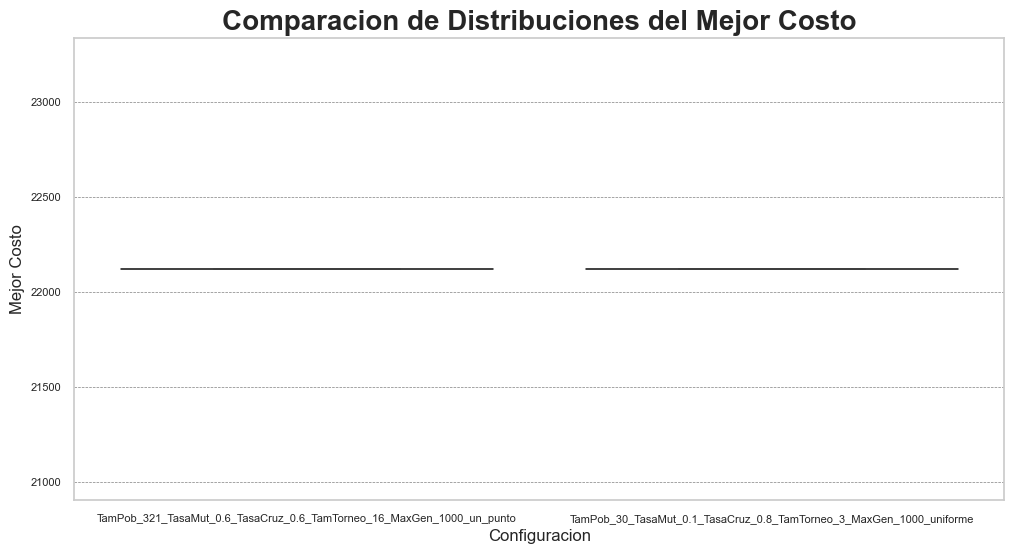

In [16]:
datos_costos = {nombre_configuracion: [res["mejor_costo"] for res in resultados_ejecuciones] for nombre_configuracion, resultados_ejecuciones in resultados.items()}
plt.figure()
sns.boxplot(data=pd.DataFrame(datos_costos)).set(
    xlabel="Configuracion",
    ylabel="Mejor Costo",
    title="Comparacion de Distribuciones del Mejor Costo"
)
plt.savefig(os.path.join(path, file_name, f"comparacion-soluciones.pdf"), bbox_inches='tight')
plt.show()
plt.close()

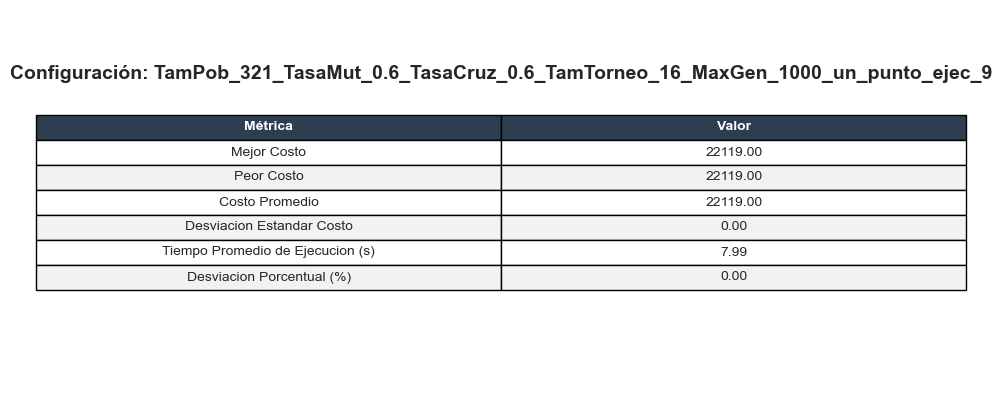

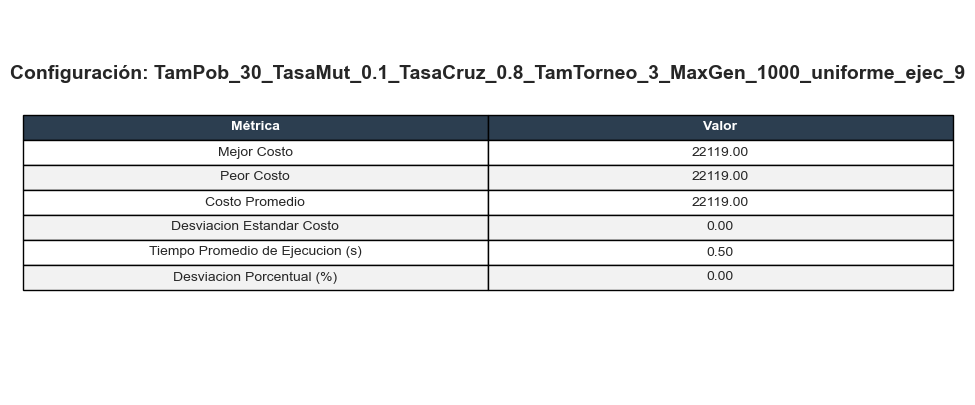

In [17]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os

# Ruta del PDF de salida
pdf_path = os.path.join(path, file_name, "resumenes_tablas.pdf")

# Guardar todas las tablas en un solo PDF
with PdfPages(pdf_path) as pdf:
    for nombre_configuracion, resumen_df in tablas_resumen.items():
        fig, ax = plt.subplots(figsize=(12, 0.5 * len(resumen_df) + 2))  # Tamaño ajustado a la cantidad de filas
        ax.axis('off')
        ax.axis('tight')

        # Crear tabla
        tabla = ax.table(cellText=resumen_df.values,
                         colLabels=resumen_df.columns,
                         loc='center',
                         cellLoc='center',
                         colColours=["#2C3E50"] * len(resumen_df.columns))  # Encabezado con color

        # Formato
        tabla.auto_set_font_size(False)
        tabla.set_fontsize(10)
        tabla.scale(1, 1.5)

        # Aplicar estilos a las celdas
        for (row, col), cell in tabla.get_celld().items():
            cell.set_edgecolor('black')  # Borde negro para todas las celdas
            if row == 0:
                cell.set_text_props(weight='bold', color='white')  # Encabezado blanco y en negrita
                cell.set_facecolor('#2C3E50')  # Fondo del encabezado
            else:
                cell.set_facecolor('#F2F2F2' if row % 2 == 0 else 'white')  # Alternar colores de fila

        # Título por configuración
        plt.title(f"Configuración: {nombre_configuracion}_ejec_{num_ejecuciones}", fontsize=14, weight='bold', pad=-50)
        pdf.savefig(fig, bbox_inches='tight')
        plt.show()
        plt.close()